In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from keras import Input
from keras.models import Model, load_model, save_model
from keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, \
    concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

from dice_func import *
from unet import *

C:\Users\User\AppData\Local\Temp\ipykernel_9144\3906669198.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Setting Size Parameters of images
img_width = 256
img_height = 256

## Loading Image and Mask Paths

In [6]:
image_filenames_train = []

# Creating a list of all the images containing the word mask
mask_files = glob('data/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace("_mask", ""))
    
print(image_filenames_train[:10])
len(image_filenames_train)

['data/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', 'data/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', 'data/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', 'data/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', 'data/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif', 'data/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif', 'data/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_16.tif', 'data/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_17.tif', 'data/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_18.tif', 'data/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_19.tif']


3929

## Plotting few images and masks

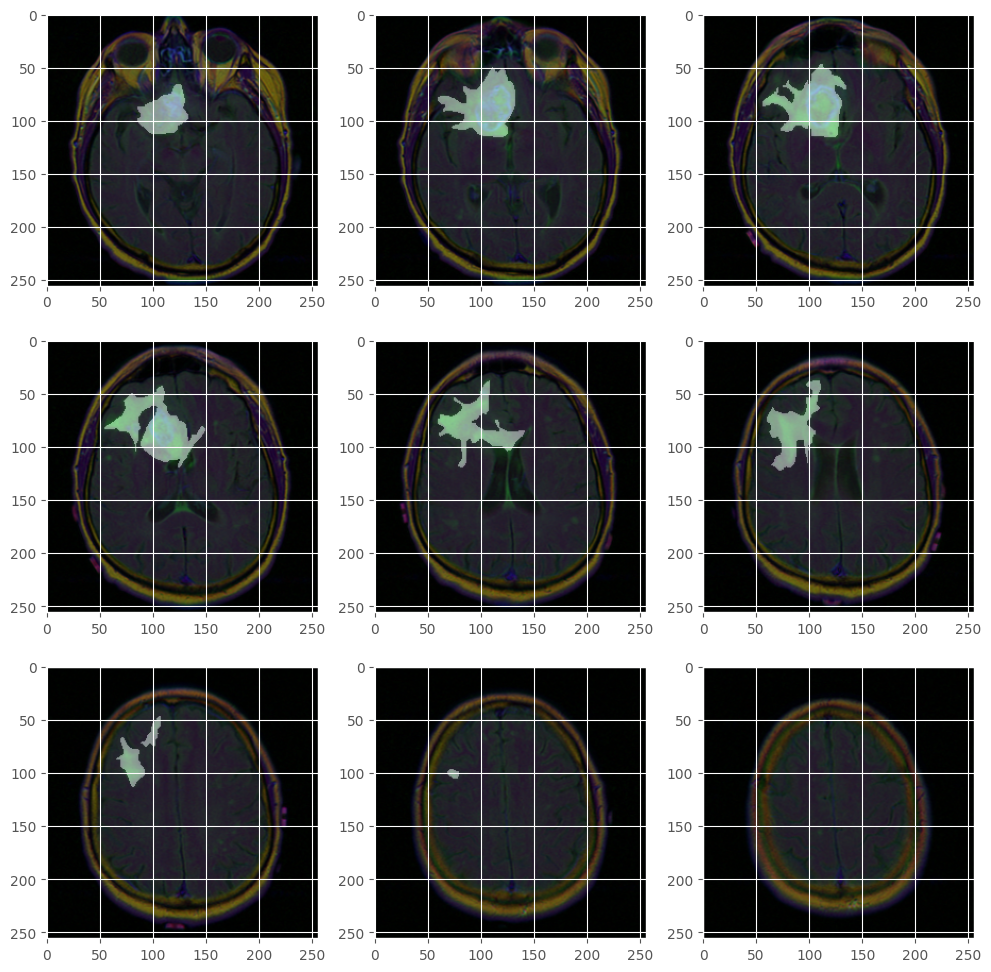

In [7]:
plot_from_img_path(3,3, image_filenames_train, mask_files)

## Create Dataframe and split data on train set, validation set and test set

In [8]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, "mask" : mask_files})

In [9]:
df_train, df_test = train_test_split(df, test_size=0.1) # Test Size - 0.1 means 10%

# Further split this into val and test
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2828, 2)
(393, 2)
(708, 2)


In [10]:
''' After mask Normalization if the value is <= 0.5 then that Mask 
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

## **Data generator, data augmentation and adjust data**

In [11]:
# Referring from https://github.com/zhixuhao/unet/blob/master/data.py

def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [12]:
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4
smooth = 100

In [13]:
model = unet()
model.summary

<bound method Model.summary of <keras.src.engine.functional.Functional object at 0x000002C82D1634D0>>

In [ ]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(img_height, img_width))
    
test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(img_height, img_width))
    
model = unet(input_size=(img_height, img_width, 3))



decay_rate = learning_rate / EPOCHS

opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7, weight_decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficient_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

In [18]:
model = load_model('./unet.hdf', custom_objects={'dice_coefficient_loss': dice_coefficient_loss, 'iou': iou, 'dice_coefficients': dice_coefficients  } )

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(img_height, img_width)  )

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )


## Plotting Predicted Masks Segmentation results from the Test Image set

1/1 [==============================] - 2s 2s/step


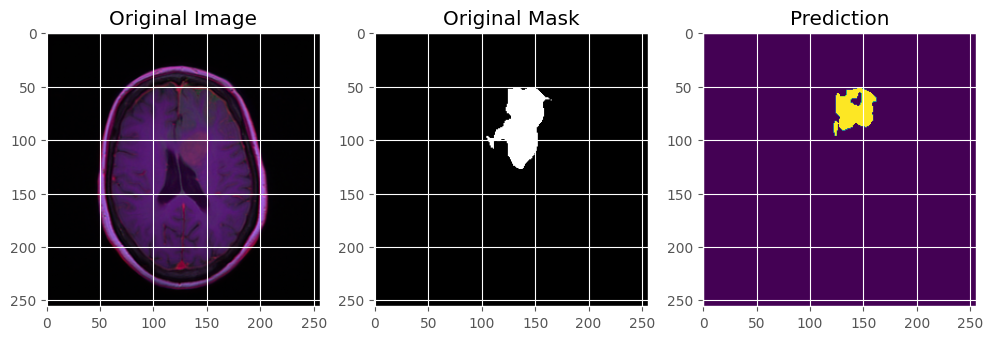

1/1 [==============================] - 1s 861ms/step


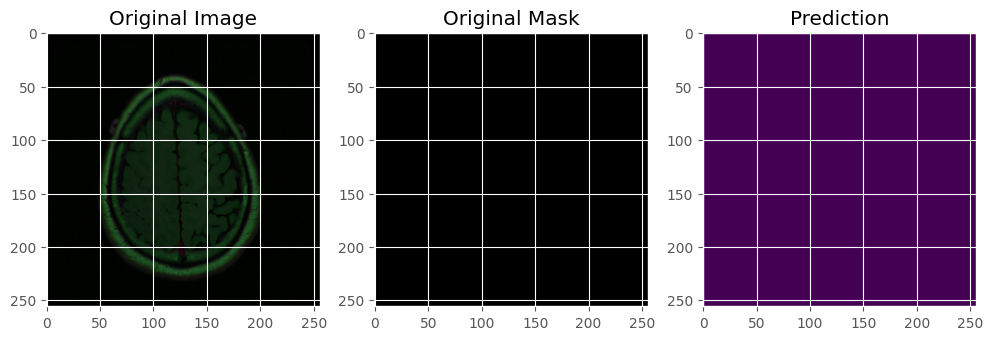

1/1 [==============================] - 1s 816ms/step


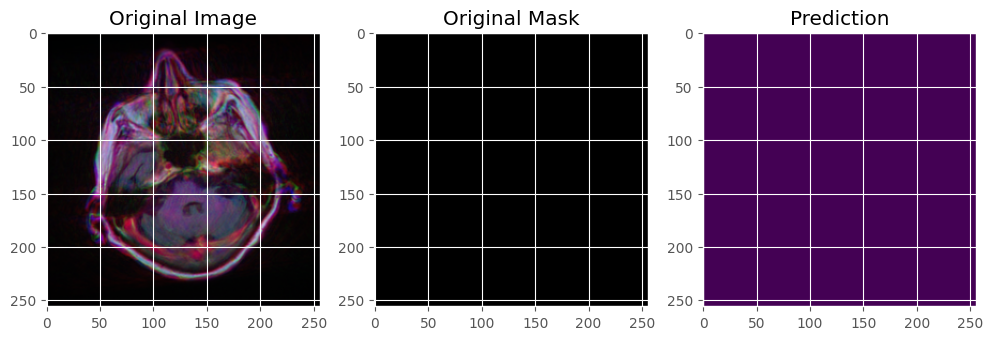

1/1 [==============================] - 1s 790ms/step


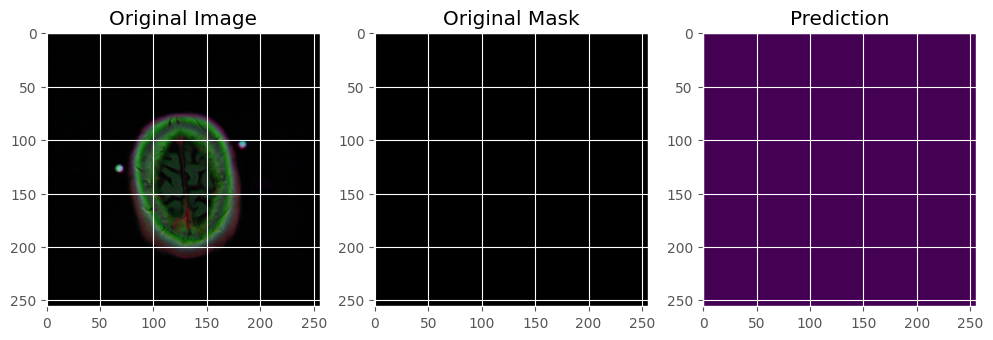

1/1 [==============================] - 1s 767ms/step


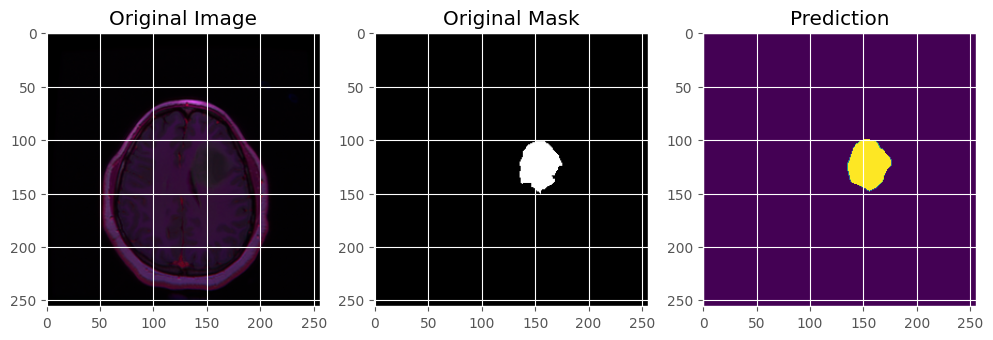

1/1 [==============================] - 1s 827ms/step


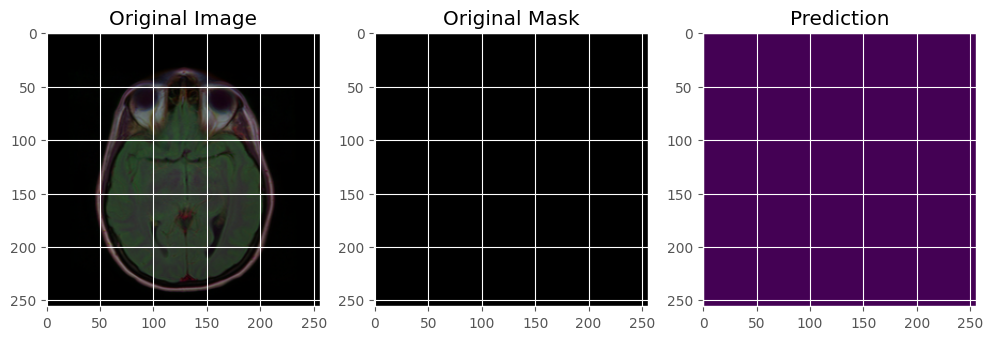

1/1 [==============================] - 1s 761ms/step


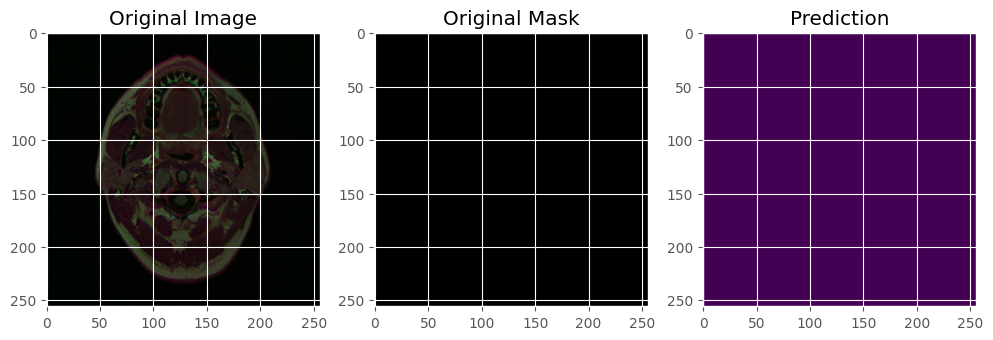

1/1 [==============================] - 1s 818ms/step


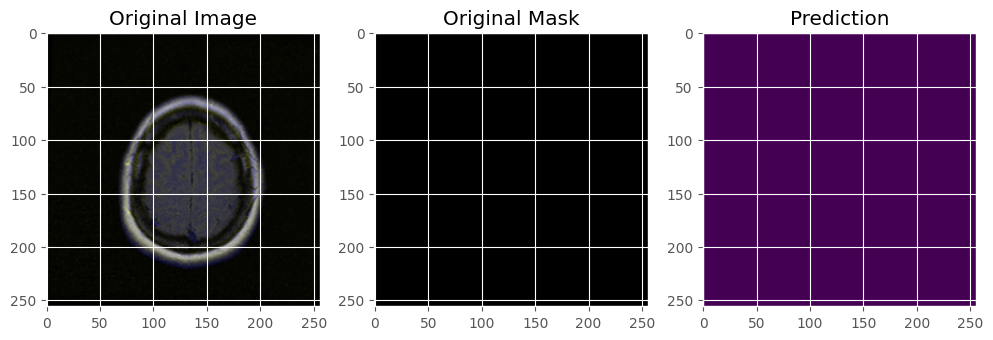

1/1 [==============================] - 1s 880ms/step


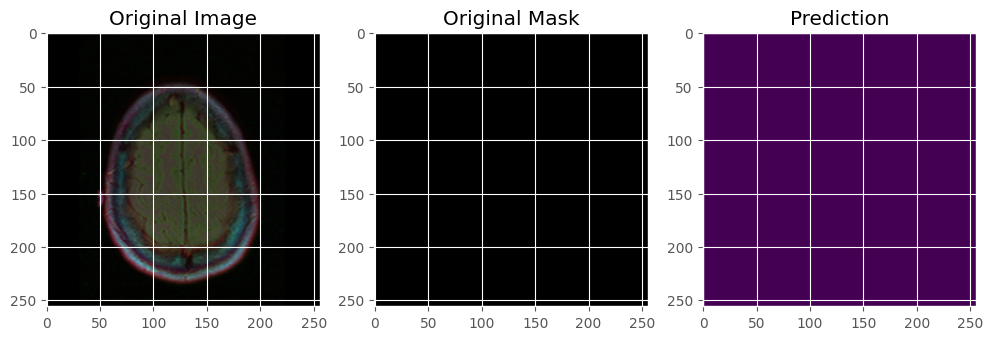

1/1 [==============================] - 1s 773ms/step


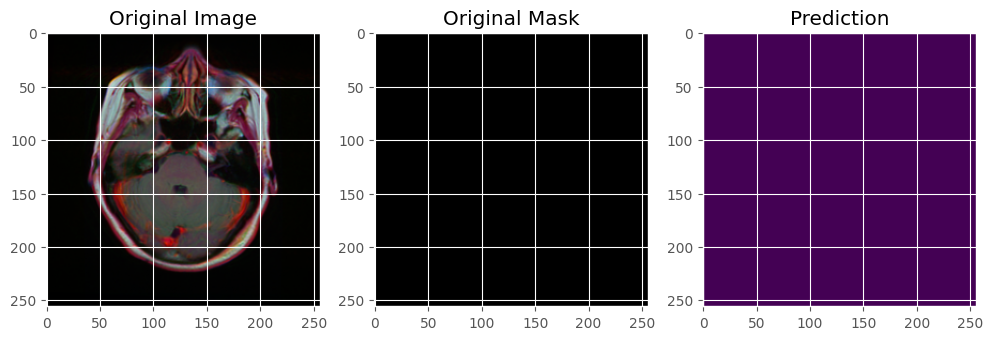

1/1 [==============================] - 1s 796ms/step


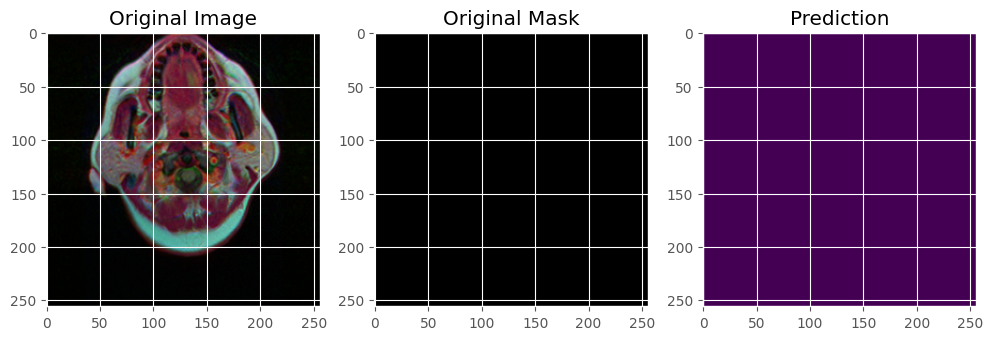

1/1 [==============================] - 1s 846ms/step


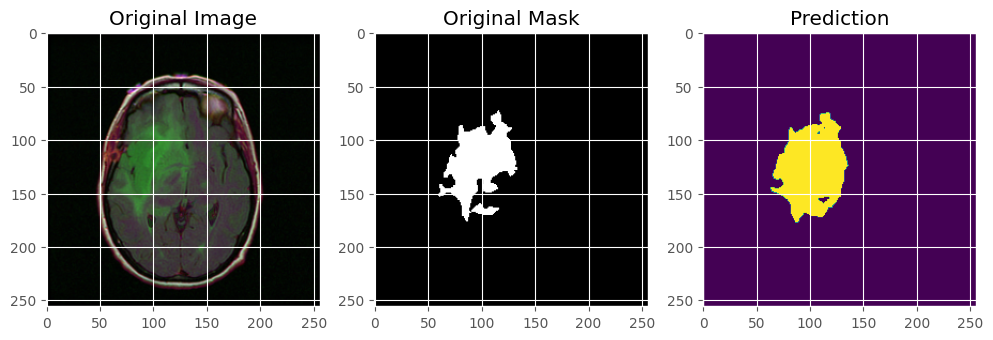

1/1 [==============================] - 1s 774ms/step


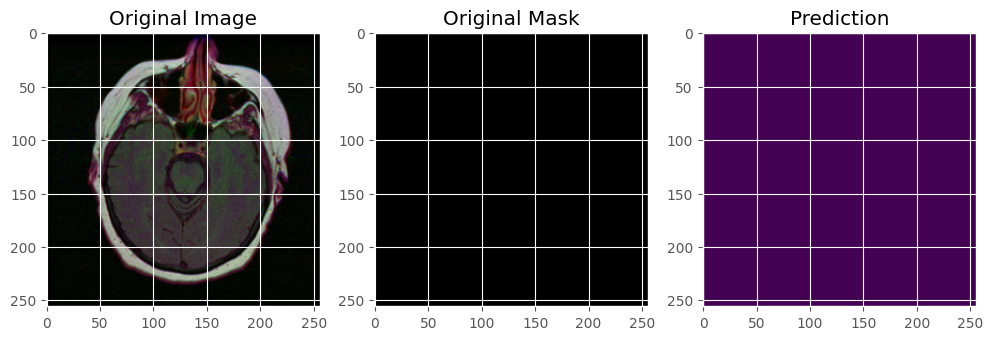

1/1 [==============================] - 1s 785ms/step


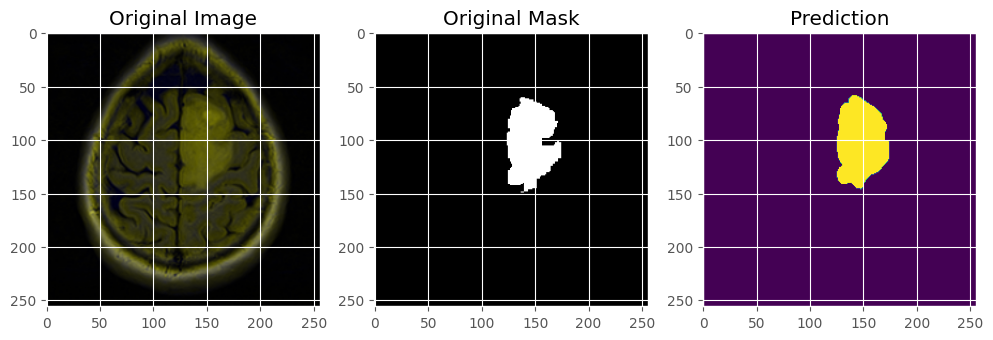

1/1 [==============================] - 1s 790ms/step


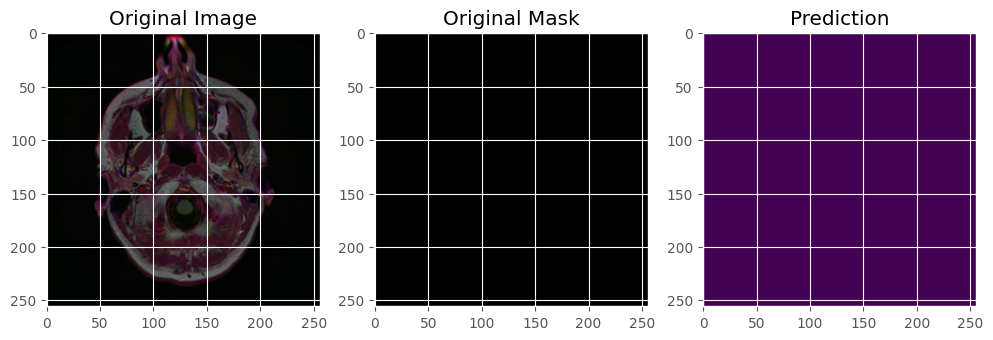

1/1 [==============================] - 1s 815ms/step


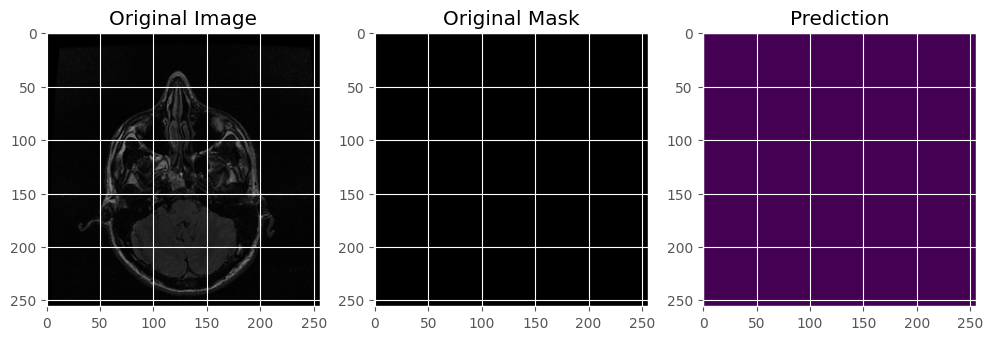

1/1 [==============================] - 1s 768ms/step


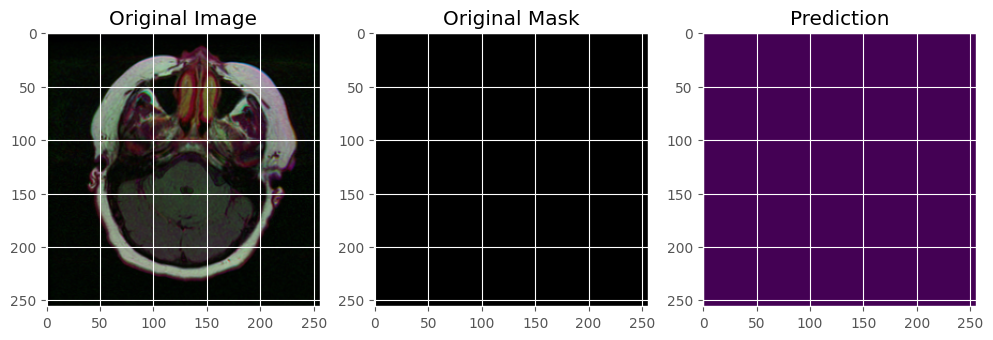

1/1 [==============================] - 1s 787ms/step


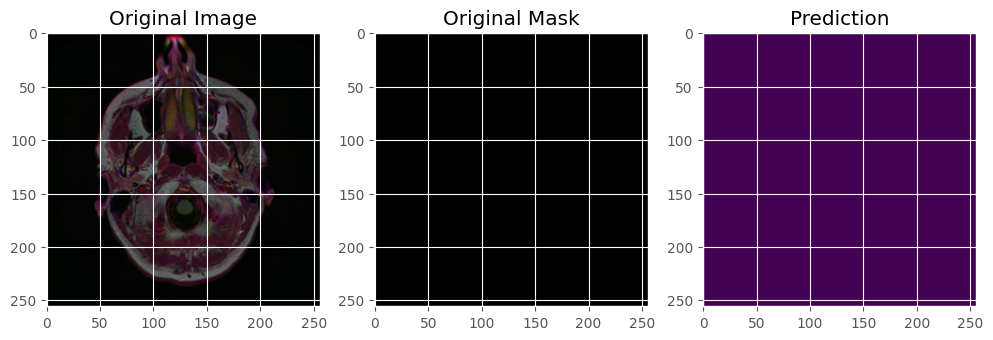

1/1 [==============================] - 1s 782ms/step


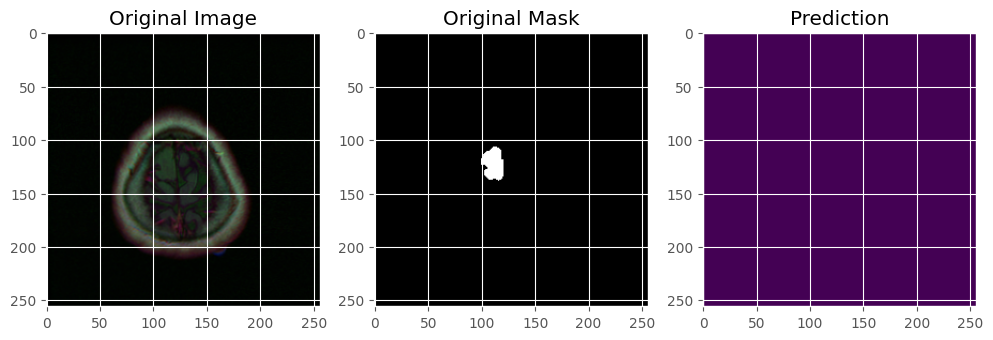

1/1 [==============================] - 1s 795ms/step


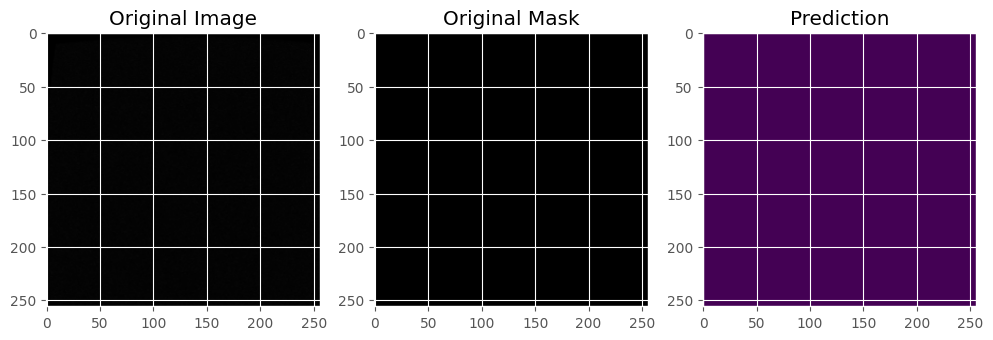

In [15]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (img_height, img_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    # Assuming predicted_image is your NumPy array
    predicted_img = predicted_img.squeeze()  # Remove the extra dimension
    predicted_img = (predicted_img * 255).astype(np.uint8)  # Convert to 8-bit format

    # cv2.imshow('Predicted Image', predicted_img)
    # cv2.waitKey(0)  # Keep the window open until a key is pressed
    # cv2.destroyAllWindows()  # Close the window when done



    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()

    

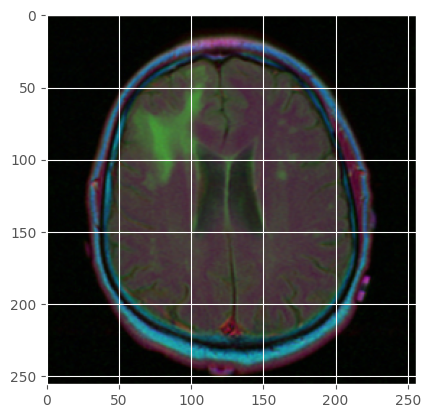

In [22]:
img = cv2.imread("./prediction_image.tif")
plt.imshow(img)

1/1 [==============================] - 1s 762ms/step


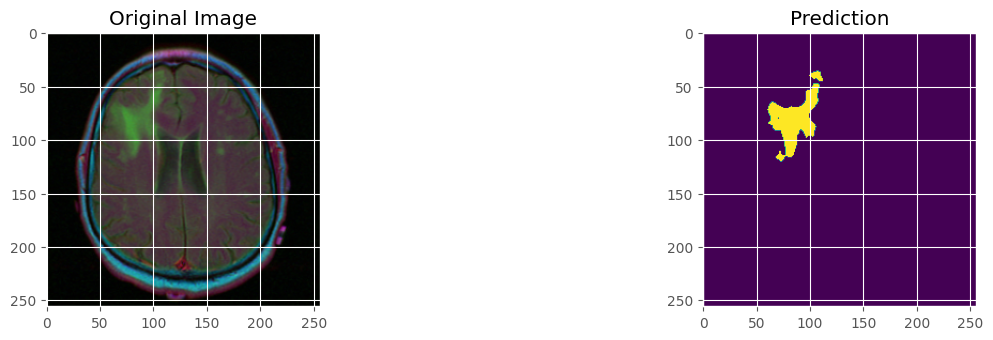

In [23]:
img = cv2.resize(img, (img_height, img_width))
img = img/255
# print(imgs.shape) (256, 256 , 3)
img = img[np.newaxis, :, :, : ]
# print(img.shape) # (1, 256, 256, 3)

predicted_img = model.predict(img)


# # Assuming predicted_image is your NumPy array
predicted_img = predicted_img.squeeze()  # Remove the extra dimension
predicted_img = (predicted_img * 255).astype(np.uint8)


plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(img))
plt.title('Original Image')


plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predicted_img) > 0.5 )
plt.title('Prediction')
plt.show()

TypeError: Can't convert object to 'str' for 'filename'

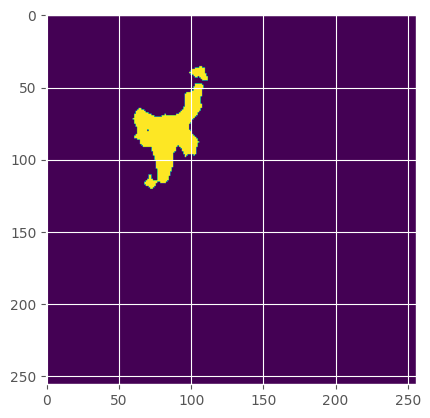